# PROYECTO POLISOMNOGRAMA
## CIENCIA DE DATOS EN BIOMEDICINA
### ÁNGEL GUEVARA Y ARTURO SIRVENT

In [1]:
# Módulos 

# Básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Análisis sueño
import mne 
import yasa

# Modelado
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

# Evaluación 
from sklearn.metrics import plot_roc_curve, classification_report, confusion_matrix

## Leemos las señales y las preprocesamos

In [2]:
# Leemos los datos
raw_8 = mne.io.read_raw_edf('./raw_data/8/8.edf', preload=True)
raw_9 = mne.io.read_raw_edf('./raw_data/9/9.edf', preload=True)
raw_10 = mne.io.read_raw_edf('./raw_data/10/10.edf', preload=True)

Extracting EDF parameters from C:\Users\Usuario\MCD\CDB\Proyecto_Polisomnograma\raw_data\8\8.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5999999  =      0.000 ... 29999.995 secs...
Extracting EDF parameters from C:\Users\Usuario\MCD\CDB\Proyecto_Polisomnograma\raw_data\9\9.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5813999  =      0.000 ... 29069.995 secs...
Extracting EDF parameters from C:\Users\Usuario\MCD\CDB\Proyecto_Polisomnograma\raw_data\10\10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4775999  =      0.000 ... 23879.995 secs...


In [3]:
# Nos quedamos solo con los canales que nos interesen 


print(raw_9.ch_names)

raw_8.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_9.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

raw_10.drop_channels(['ROC-A1', 'F3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 
                   'SaO2', 'DC8'])

['LOC-A2', 'ROC-A1', 'F3-A2', 'C3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'DC3', 'X7', 'X8', 'SaO2', 'DC8']


<RawEDF | 10.edf, 3 x 4776000 (23880.0 s), ~109.3 MB, data loaded>

In [4]:
# Reducimos las muestras a la mitad haciendo un downsampling. Es decir, en vez de coger 200 tomas por segundo, cogeremos 100.
raw_8.resample(100)
sf8 = raw_8.info['sfreq']

raw_9.resample(100)
sf9 = raw_9.info['sfreq']

raw_10.resample(100)
sf10 = raw_10.info['sfreq']

In [5]:
# Además, aplicamos un filtro de pasa-banda porque las frecuencias de interés están en un rango de 0-30 aprox

raw_8.filter(0.3, 49.99)
raw_9.filter(0.3, 49.99)
raw_10.filter(0.3, 45)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 49.99 Hz
- Upper transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 50.00 Hz)
- Filter length: 33001 samples (330.010 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passban

<RawEDF | 10.edf, 3 x 2388000 (23880.0 s), ~54.7 MB, data loaded>

In [6]:
# Podemos acceder a los datos de la siguiente manera

data8 = raw_8.get_data() * 1e6
print(data8.shape)

data9 = raw_9.get_data() * 1e6
print(data9.shape)

data10 = raw_10.get_data() * 1e6
print(data10.shape)

(3, 3000000)
(3, 2907000)
(3, 2388000)


In [7]:
# Quitamos las últimas 30 épocas, para ello, tenedremos que restar 30 épocas, de 30 segundos cada una, dónde 1 segundo son 100 
# tomas. 
# En resumen, quitamos las últimas 30*30*100 muestras.

ultimas_30 = 30*30*100

data8 = data8[:,0:-ultimas_30]

data9 = data9[:,0:-ultimas_30]

data10 = data10[:,0:-ultimas_30]


In [8]:
print(data8.shape)
print(data9.shape)
print(data10.shape)

(3, 2910000)
(3, 2817000)
(3, 2298000)


In [9]:
# Quitamos las últimas 30 épocas del objeto row también para que no haya problemas en las funciones espectrales que usaremos
# más adelante. 

raw_8.crop(0,data8.shape[1]/100, include_tmax = False)

raw_9.crop(0,data9.shape[1]/100, include_tmax = False)

raw_10.crop(0,data10.shape[1]/100, include_tmax = False)

<RawEDF | 10.edf, 3 x 2298000 (22980.0 s), ~52.6 MB, data loaded>

In [10]:
# Importamos las etiquetas de cada señal. Estas han sido puestas por dos expertos distintos que han estado en completa 
# concordancia. Se encuentran en los ficheros de texto correspondientes.


hypno8 = pd.read_csv("./raw_data/8/8_1.txt", squeeze=True, header=None)
hypno9 = pd.read_csv("./raw_data/9/9_1.txt", squeeze=True, header=None)
hypno10 = pd.read_csv("./raw_data/10/10_1.txt", squeeze=True, header=None)

#Las etiquetas vienen codificadas con los números 0,1,2,3,5
print(hypno8.unique())
print(hypno9.unique())
print(hypno10.unique())

[0 1 2 3 5]
[0 1 2 3 5]
[0 1 2 3 5]


<AxesSubplot:xlabel='Time [hrs]', ylabel='Stage'>

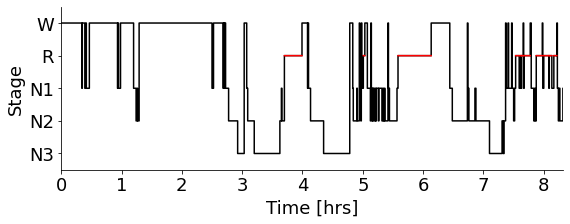

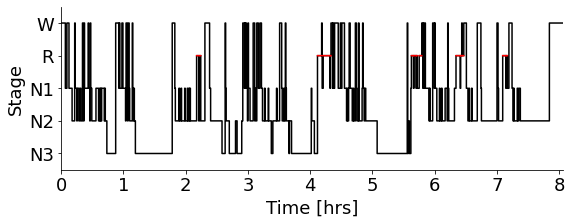

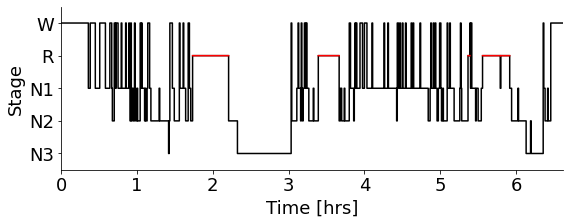

In [11]:
# Renombramos la clase 5 como clase 4 para que no de problemas las funciones. 

for i in range(hypno8.shape[0]):
    if hypno8.values[i]==5:
        hypno8.values[i]=4
        
for i in range(hypno9.shape[0]):
    if hypno9.values[i]==5:
        hypno9.values[i]=4
        
for i in range(hypno10.shape[0]):
    if hypno10.values[i]==5:
        hypno10.values[i]=4
        
        
# Los dibujamos
yasa.plot_hypnogram(hypno8)
yasa.plot_hypnogram(hypno9)
yasa.plot_hypnogram(hypno10)

In [12]:
# Recordemos que las etiquetas las teníamos en la variable `hypno`
# quitamos las últimas 30 épocas en cada caso ya que éstas no hay que tenerlas en cuenta.


# Sujeto 8
labels8 = hypno8[0:-30]
print(labels8.shape)

# Sujeto 9
labels9 = hypno9[0:-30]
print(labels9.shape)

# Sujeto 10
labels10 = hypno10[0:-30]
print(labels10.shape)

(970,)
(939,)
(766,)


## Troceamos en intervalos de 30 segundos.

In [13]:
# Sujeto 8
data8_2 = []
cortes8 = (data8.shape[1]/sf8) / 30

for i in range(data8.shape[0]):
        data8_2.append(np.split(data8[i], cortes8))

# Sujeto 9
data9_2 = []
cortes9 = (data9.shape[1]/sf9) / 30

for i in range(data9.shape[0]):
        data9_2.append(np.split(data9[i], cortes9))
        
# Sujeto 10
data10_2 = []
cortes10 = (data10.shape[1]/sf10) / 30

for i in range(data10.shape[0]):
        data10_2.append(np.split(data10[i], cortes10))

In [14]:
# Transformamos en array la lista con los cortes hechos

# Sujeto 8
data8_2 = np.array(data8_2)
print(data8_2.shape)

# Sujeto 9
data9_2 = np.array(data9_2)
print(data9_2.shape)

# Sujeto 10
data10_2 = np.array(data10_2)
print(data10_2.shape)

(3, 970, 3000)
(3, 939, 3000)
(3, 766, 3000)


## Extraemos características 

En una primera aproximación, sacaremos las medias y las desviaciones típicas de tramo de 30 segundos en cada canal.

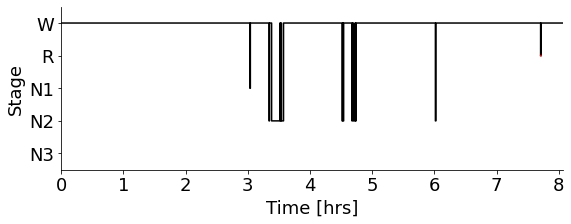

In [15]:
# Sujeto 8
sls8 = yasa.SleepStaging(raw_8, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred8 = sls8.predict()  # Predict the sleep stages
hypno_pred8 = yasa.hypno_str_to_int(hypno_pred8)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred8); 

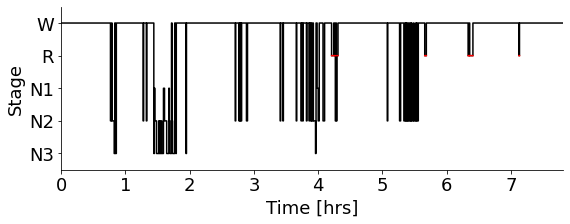

In [16]:
# Sujeto 9
sls9 = yasa.SleepStaging(raw_9, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred9 = sls9.predict()  # Predict the sleep stages
hypno_pred9 = yasa.hypno_str_to_int(hypno_pred9)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred9); 

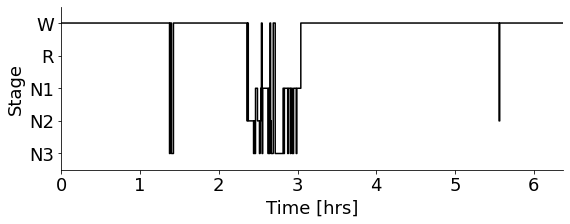

In [17]:
# Sujeto 10
sls10 = yasa.SleepStaging(raw_10, eeg_name='C3-A2', eog_name='LOC-A2', emg_name='X1')
hypno_pred10 = sls10.predict()  # Predict the sleep stages
hypno_pred10 = yasa.hypno_str_to_int(hypno_pred10)  # Convert "W" to 0, "N1" to 1, etc
yasa.plot_hypnogram(hypno_pred10); 

In [18]:
# Sujeto 8
features_8 = sls8.get_features()
# Sujeto 9
features_9 = sls9.get_features()
# Sujeto 10
features_10 = sls10.get_features()

In [23]:
features_8

,eeg_abspow,eeg_abspow_c7min_norm,eeg_abspow_p2min_norm,eeg_alpha,eeg_alpha_c7min_norm,eeg_alpha_p2min_norm,eeg_at,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_beta,...,eog_skew_c7min_norm,eog_skew_p2min_norm,eog_std,eog_std_c7min_norm,eog_std_p2min_norm,eog_theta,eog_theta_c7min_norm,eog_theta_p2min_norm,time_hour,time_norm
epoch,,,,,,,,,,,,,,,,,,,,,
0,4.545341,0.931674,1.205143,0.289044,0.432505,0.260559,3.837966,0.631870,0.505437,0.305399,...,-0.561162,-0.483046,3.931506,1.239759,2.067270,0.066370,-0.615230,-0.582441,0.000000,0.000000
1,5.240892,0.912996,1.436574,0.262013,0.455877,0.234352,3.482800,0.645939,0.476353,0.261714,...,-0.564484,-0.430728,4.236856,1.121821,2.210652,0.061887,-0.612157,-0.597417,0.008333,0.001032
2,3.053210,0.844773,1.028447,0.353350,0.480600,0.284652,3.562622,0.657804,0.471016,0.288139,...,-0.577619,-0.467211,2.171065,0.982754,1.611764,0.071202,-0.606614,-0.581663,0.016667,0.002064
3,3.652775,0.793848,0.924130,0.451407,0.501728,0.357336,4.808928,0.669421,0.519377,0.225975,...,-0.583573,-0.531085,2.639289,0.874477,1.422251,0.058757,-0.600190,-0.594574,0.025000,0.003096
4,3.164528,0.743629,0.694412,0.431922,0.519175,0.426598,5.049477,0.675600,0.568981,0.271876,...,-0.581902,-0.548754,1.826683,0.764979,0.928076,0.077217,-0.593656,-0.576455,0.033333,0.004128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
965,2.297324,-0.177384,-0.195025,0.159416,-0.022214,-0.029946,0.965867,-0.011093,-0.011365,0.246440,...,0.282269,0.041927,2.299645,0.165806,0.278790,0.138692,0.156989,0.009874,8.041667,0.995872
966,2.625368,-0.175691,-0.206395,0.155437,-0.022868,-0.021721,0.677207,-0.011653,-0.010807,0.253879,...,0.318626,0.142642,1.703428,0.160056,0.202415,0.171430,0.159250,-0.001860,8.050000,0.996904
967,2.702834,-0.171998,-0.173341,0.146006,-0.024636,-0.019809,0.621968,-0.012488,-0.010523,0.250021,...,0.338902,0.309921,1.816432,0.162425,0.187248,0.183805,0.166044,0.064889,8.058333,0.997936


In [24]:
features_9

,eeg_abspow,eeg_abspow_c7min_norm,eeg_abspow_p2min_norm,eeg_alpha,eeg_alpha_c7min_norm,eeg_alpha_p2min_norm,eeg_at,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_beta,...,eog_skew_c7min_norm,eog_skew_p2min_norm,eog_std,eog_std_c7min_norm,eog_std_p2min_norm,eog_theta,eog_theta_c7min_norm,eog_theta_p2min_norm,time_hour,time_norm
epoch,,,,,,,,,,,,,,,,,,,,,
0,2.236699,-0.086209,-0.087006,0.133311,0.686315,0.322667,0.925211,1.143239,0.474665,0.248948,...,-0.373202,-1.296962,4.451709,0.798881,2.685668,0.097917,-0.475691,-0.345623,0.000000,0.000000
1,2.522212,-0.088422,-0.062275,0.148000,0.712782,0.391317,0.920996,1.178537,0.471652,0.213697,...,-0.288307,-0.793395,3.142569,0.607898,2.030537,0.050526,-0.475603,-0.558052,0.008333,0.001066
2,2.102220,-0.092707,-0.078284,0.221685,0.736335,0.643779,2.052389,1.216157,1.009845,0.293267,...,-0.230030,-0.546821,1.549476,0.430264,1.280674,0.087148,-0.464159,-0.519425,0.016667,0.002132
3,2.615744,-0.095529,-0.064048,0.201452,0.724494,0.722729,1.370815,1.177252,1.035324,0.286054,...,-0.184460,-0.441137,1.856461,0.303849,0.982554,0.097280,-0.448160,-0.477402,0.025000,0.003198
4,1.859047,-0.100567,-0.080404,0.174524,0.697243,0.819033,1.309697,1.129465,1.172752,0.296029,...,-0.154348,-0.115706,1.580510,0.204462,0.264139,0.113959,-0.440698,-0.441449,0.033333,0.004264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
934,3.215868,0.079294,0.046847,0.072652,-0.085750,-0.080221,0.488856,-0.095791,-0.049009,0.102038,...,0.202259,0.281474,1.793841,-0.035141,-0.103586,0.170654,0.258794,0.299283,7.783333,0.995736
935,3.348229,0.088305,0.042951,0.091021,-0.099223,-0.025130,0.643512,-0.102956,0.015782,0.105900,...,0.173266,0.192724,1.929023,-0.015118,-0.032934,0.119026,0.240071,0.265505,7.791667,0.996802
936,3.571526,0.097398,0.083532,0.057302,-0.114480,-0.135716,0.358100,-0.116491,-0.089600,0.087399,...,0.142119,0.057820,1.846464,0.002999,0.042097,0.137828,0.235847,0.204676,7.800000,0.997868


In [21]:
print(classification_report(labels9, hypno_pred9))

              precision    recall  f1-score   support

           0       0.15      0.99      0.26       122
           1       0.00      0.00      0.00       167
           2       0.04      0.01      0.01       362
           3       0.93      0.12      0.21       225
           4       0.89      0.27      0.41        63

    accuracy                           0.18       939
   macro avg       0.40      0.28      0.18       939
weighted avg       0.32      0.18      0.12       939



In [127]:
# Creamos un dataframe con las medias de cada tramo de 30 segundos de cada canal.

# Sujeto 8
medias8 = np.mean(data8_2, axis=2)
dv8 = np.std(data8_2, axis=2)
print(medias8.shape)

# Sujeto 9
medias9 = np.mean(data9_2, axis=2)
dv9 = np.std(data9_2, axis=2)
print(medias9.shape)

# Sujeto 10
medias10 = np.mean(data10_2, axis=2)
dv10 = np.std(data10_2, axis=2)
print(medias10.shape)


(3, 970)
(3, 939)
(3, 766)


In [128]:
# Sujeto 8
medias8 = pd.DataFrame(medias8)
dv8 = pd.DataFrame(dv8)

X8 = medias8.append(dv8)
X8.reset_index(inplace=True, drop=True)
X8 = X8.T
X8

,0,1,2,3,4,5
0,-0.246798,-0.222549,0.081519,4.065473,3.125610,9.313466
1,0.146303,0.062167,-0.037442,4.396223,3.324696,8.421746
2,-0.075174,-0.023601,0.038587,2.323920,2.110647,11.301917
3,-0.010481,-0.010229,0.000397,2.734054,2.143127,10.986094
4,0.005192,0.007507,0.001745,1.956029,1.992863,10.568724
...,...,...,...,...,...,...
965,0.004408,0.001253,0.014603,2.449285,1.767871,10.900620
966,-0.019915,0.007619,-0.001504,1.877415,1.794883,11.065335
967,0.016392,-0.014942,0.009808,1.977605,1.847789,10.999181
968,-0.010725,0.011843,-0.014681,2.181965,1.762284,10.936826


In [129]:
# Sujeto 9
medias9 = np.mean(data9_2, axis=2)
dv9 = np.std(data9_2, axis=2)
print(medias9.shape)

medias9 = pd.DataFrame(medias9)
dv9 = pd.DataFrame(dv9)

X9 = medias9.append(dv9)
X9.reset_index(inplace=True, drop=True)
X9 = X9.T
X9

(3, 939)


,0,1,2,3,4,5
0,-0.188599,-0.177499,0.185917,4.541549,2.095968,11.016487
1,-0.026260,-0.005257,-0.059490,3.316682,1.870881,11.315255
2,0.033135,-0.004643,-0.035357,1.735889,1.688281,10.963824
3,-0.021494,0.000988,-0.068317,1.973163,1.877921,11.708515
4,0.014872,0.004850,0.078322,1.750603,1.621589,10.837923
...,...,...,...,...,...,...
934,0.009455,0.011622,0.032522,1.911315,2.300108,10.055428
935,-0.018744,-0.006811,-0.000571,2.038211,2.863851,10.009552
936,-0.000394,-0.002746,-0.006643,1.944910,2.332082,10.205744
937,-0.003346,0.003961,-0.029413,1.807678,1.859118,10.062265


In [22]:
# Unimos los dos dataframes de características en uno solo


#X = X8.append(X9)
#X.reset_index(inplace=True, drop=True)
#X

X= features_8.append(features_9)
X.reset_index(inplace=True, drop=True)
X

,eeg_abspow,eeg_abspow_c7min_norm,eeg_abspow_p2min_norm,eeg_alpha,eeg_alpha_c7min_norm,eeg_alpha_p2min_norm,eeg_at,eeg_at_c7min_norm,eeg_at_p2min_norm,eeg_beta,...,eog_skew_c7min_norm,eog_skew_p2min_norm,eog_std,eog_std_c7min_norm,eog_std_p2min_norm,eog_theta,eog_theta_c7min_norm,eog_theta_p2min_norm,time_hour,time_norm
0,4.545341,0.931674,1.205143,0.289044,0.432505,0.260559,3.837966,0.631870,0.505437,0.305399,...,-0.561162,-0.483046,3.931506,1.239759,2.067270,0.066370,-0.615230,-0.582441,0.000000,0.000000
1,5.240892,0.912996,1.436574,0.262013,0.455877,0.234352,3.482800,0.645939,0.476353,0.261714,...,-0.564484,-0.430728,4.236856,1.121821,2.210652,0.061887,-0.612157,-0.597417,0.008333,0.001032
2,3.053210,0.844773,1.028447,0.353350,0.480600,0.284652,3.562622,0.657804,0.471016,0.288139,...,-0.577619,-0.467211,2.171065,0.982754,1.611764,0.071202,-0.606614,-0.581663,0.016667,0.002064
3,3.652775,0.793848,0.924130,0.451407,0.501728,0.357336,4.808928,0.669421,0.519377,0.225975,...,-0.583573,-0.531085,2.639289,0.874477,1.422251,0.058757,-0.600190,-0.594574,0.025000,0.003096
4,3.164528,0.743629,0.694412,0.431922,0.519175,0.426598,5.049477,0.675600,0.568981,0.271876,...,-0.581902,-0.548754,1.826683,0.764979,0.928076,0.077217,-0.593656,-0.576455,0.033333,0.004128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1904,3.215868,0.079294,0.046847,0.072652,-0.085750,-0.080221,0.488856,-0.095791,-0.049009,0.102038,...,0.202259,0.281474,1.793841,-0.035141,-0.103586,0.170654,0.258794,0.299283,7.783333,0.995736
1905,3.348229,0.088305,0.042951,0.091021,-0.099223,-0.025130,0.643512,-0.102956,0.015782,0.105900,...,0.173266,0.192724,1.929023,-0.015118,-0.032934,0.119026,0.240071,0.265505,7.791667,0.996802
1906,3.571526,0.097398,0.083532,0.057302,-0.114480,-0.135716,0.358100,-0.116491,-0.089600,0.087399,...,0.142119,0.057820,1.846464,0.002999,0.042097,0.137828,0.235847,0.204676,7.800000,0.997868
1907,3.030310,0.104469,0.095726,0.120380,-0.112137,-0.125735,0.579618,-0.114636,-0.108224,0.157947,...,0.120864,0.066141,1.666218,0.019753,0.040580,0.194055,0.243602,0.169616,7.808333,0.998934


In [25]:
# Unimos también las etiquetas 

labels= labels8.append(labels9)
labels.reset_index(inplace=True, drop=True)
labels

0       0
1       0
2       0
3       0
4       0
       ..
1904    2
1905    2
1906    2
1907    2
1908    2
Name: 0, Length: 1909, dtype: int64

In [26]:
# Dividimos en train y test 

x_train, x_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=0)


In [28]:
# Hacemos un Random Forest con las medias de cada tramo de cada canal

# Buscamos los parámetros óptimos del clasificador 

RF = OneVsRestClassifier(RandomForestClassifier(random_state=0))
#params = {'n_estimators': [], 'criterion': ['gini', 'entropy'], 'max_depth':[1,2,3,4,5,6,7]}

#RF = GridSearchCV(, param_grid=
RF.fit(x_train, y_train)

preds = RF.predict(x_test)

print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       106
           1       0.72      0.63      0.67        62
           2       0.80      0.81      0.81       101
           3       0.86      0.94      0.90        71
           4       0.95      0.93      0.94        42

    accuracy                           0.85       382
   macro avg       0.85      0.85      0.85       382
weighted avg       0.85      0.85      0.85       382



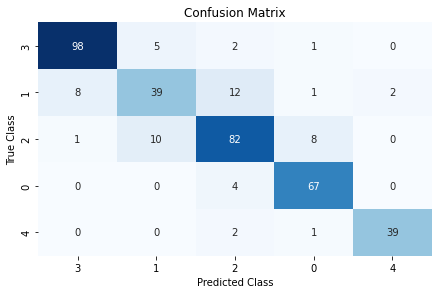

In [29]:
# Matriz de confusión 

matrix = confusion_matrix(y_test, preds)

dataframe = pd.DataFrame(matrix, index=y_test.unique(), columns=y_test.unique())

# crear mapa de calor dibujar mapa de calor
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

Text(0.5, 1.0, 'Estimador 5')

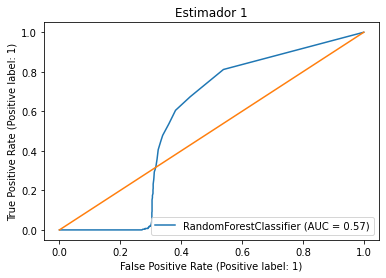

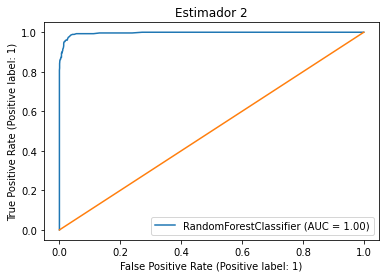

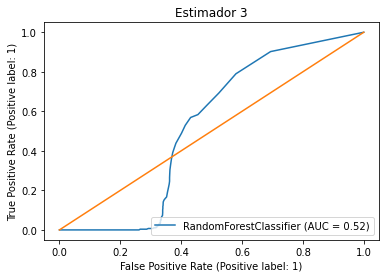

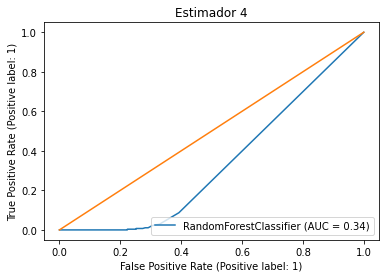

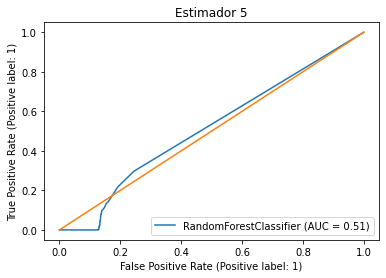

In [37]:
# Hacemos la curva ROC de cada uno de los 5 RandomForests creados para el conjunto de entrenamiento

plot_roc_curve(RF.estimators_[0], X, labels )
plt.plot([0,1],[0,1])
plt.title('Estimador 1')

plot_roc_curve(RF.estimators_[1], X, labels )
plt.plot([0,1],[0,1])
plt.title('Estimador 2')

plot_roc_curve(RF.estimators_[2], X, labels )
plt.plot([0,1],[0,1])
plt.title('Estimador 3')

plot_roc_curve(RF.estimators_[3], X, labels )
plt.plot([0,1],[0,1])
plt.title('Estimador 4')

plot_roc_curve(RF.estimators_[4], X, labels )
plt.plot([0,1],[0,1])
plt.title('Estimador 5')

Una vez entreando el modelo, hacemos las predicciones sobre el sujeto 10. Este sujeto nunca lo ha visto nuestro modelo.

In [30]:
preds_10 = RF.predict(features_10)
print(classification_report(labels10, preds_10))

              precision    recall  f1-score   support

           0       0.55      0.98      0.70       127
           1       0.74      0.45      0.56       219
           2       0.63      0.75      0.68       173
           3       0.94      0.84      0.89       112
           4       0.95      0.71      0.81       135

    accuracy                           0.71       766
   macro avg       0.76      0.74      0.73       766
weighted avg       0.75      0.71      0.70       766



Text(0.5, 1.0, 'Estimador 5')

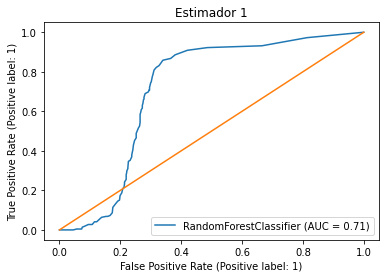

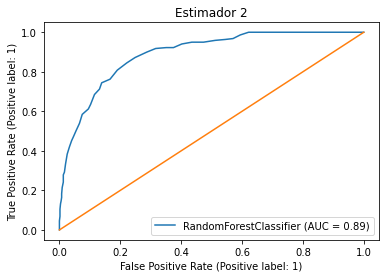

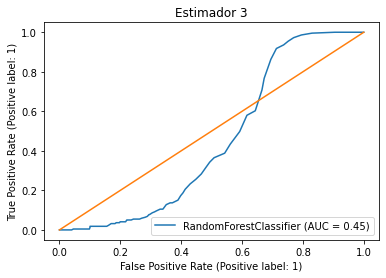

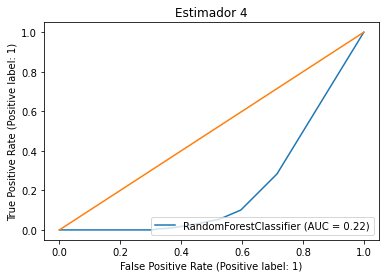

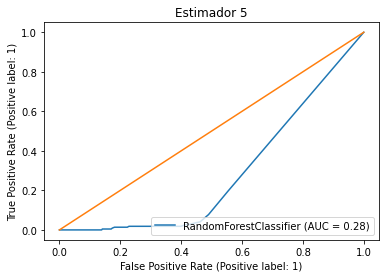

In [36]:
# Hacemos la curva ROC de cada uno de los 5 RandomForests creados. 

plot_roc_curve(RF.estimators_[0], features_10, labels10 )
plt.plot([0,1],[0,1])
plt.title('Estimador 1')

plot_roc_curve(RF.estimators_[1], features_10, labels10 )
plt.plot([0,1],[0,1])
plt.title('Estimador 2')

plot_roc_curve(RF.estimators_[2], features_10, labels10 )
plt.plot([0,1],[0,1])
plt.title('Estimador 3')

plot_roc_curve(RF.estimators_[3], features_10, labels10 )
plt.plot([0,1],[0,1])
plt.title('Estimador 4')

plot_roc_curve(RF.estimators_[4], features_10, labels10 )
plt.plot([0,1],[0,1])
plt.title('Estimador 5')

In [53]:
# Para comprobar la bondad del modelo entrenaremos con 2(8,9) pacientes y comprobaremos con 1(10) paciente.
# Cuando tengamos los 10 pacientes, usaremos 8(2:9) para train y 2(1,10) para test.

# En la hoja de excel tenemos etapa, ritmo cardíaco, eventos,... Una de las ideas es eliminar del entrenamiento todas las 
# épocas que tenga alguna anotación en eventos.
# Establecemos umbrales según las probabilidades obtenidas. Si no supera el 0.3, no se marca por ejemplo.


# Con solo tres canales es posible hacerlo.
# A3, ojo izquierdo y movimiento muscular (menton)


# EVALUACION 
# Hacer CV con el AUC sobre el conjunto de entrenamiento para ver la variabilidad del modelo. Damos la media y las Desv. Tip. 
# después del CV.
# Dar el AUC en test también.
# Idealmente se podrían dar estos datos con un boxplot.